In [4]:
import torch
import torch.nn as nn
import torchvision.models as mod
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from scipy.stats import entropy
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2

import sys

from retina.modules.evaluation import *

from retina.modules.models import RetinalDiseaseClassifier
import warnings
warnings.filterwarnings('ignore')

Checkpoint directory: /Users/gregruyoga/gmoneycodes/retina/retina/checkpoints
Directory exists: True

Loading: densenet121-epoch=24-val_f1_macro=0.8245.ckpt

Loading: resnet50-epoch=12-val_f1=0.9374.ckpt

Loading: efficientnet_b1-epoch=24-val_f1_macro=0.8427.ckpt

LOADED 3/3 MODELS



In [3]:
class SweepConfig:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

        if not hasattr(self, 'model_name'):
            self.model_name = 'resnet50'
        if not hasattr(self, 'learning_rate'):
            self.learning_rate = 0.0001
        if not hasattr(self, 'batch_size'):
            self.batch_size = 32
        if not hasattr(self, 'max_epochs'):
            self.max_epochs = 25
        if not hasattr(self, 'optimizer'):
            self.optimizer = 'adamw'
        if not hasattr(self, 'weight_decay'):
            self.weight_decay = 0.0005
        if not hasattr(self, 'loss_type'):
            self.loss_type = 'focal'
        if not hasattr(self, 'focal_alpha'):
            self.focal_alpha = 0.25
        if not hasattr(self, 'focal_gamma'):
            self.focal_gamma = 2.0
        if not hasattr(self, 'dropout_rate'):
            self.dropout_rate = 0.3
        if not hasattr(self, 'scheduler'):
            self.scheduler = 'plateau'
        if not hasattr(self, 'use_scheduler'):
            self.use_scheduler = True
        if not hasattr(self, 'pretrained'):
            self.pretrained = True
        if not hasattr(self, 'img_height'):
            self.img_height = 356

    def __repr__(self):
        attrs = ', '.join(f"{k}={v}" for k, v in self.__dict__.items())
        return f"SweepConfig({attrs})"


sys.modules['__main__'].SweepConfig = SweepConfig


In [5]:
def load_model(checkpoint_path, device='mps'):
    from pathlib import Path

    checkpoint_path = Path(checkpoint_path)
    print(f"\nLoading: {checkpoint_path.name}")

    model = RetinalDiseaseClassifier.load_from_checkpoint(
        str(checkpoint_path),
        map_location=device,
        weights_only=False
    )
    model.eval()
    model.to(device)
    return model


In [6]:
root = Path().resolve().parent.parent
checkpoint_dir = root / 'retina' / 'checkpoints'
test_dir = root / 'retina' / 'data' / 'Test_Set' / 'Test_Set' / 'Test'

print(f"Checkpoint directory: {checkpoint_dir}")
print(f"Directory exists: {checkpoint_dir.exists()}")

models_to_load = {
    "DenseNet121": "densenet121-epoch=24-val_f1_macro=0.8245.ckpt",
    "ResNet50": "resnet50-epoch=12-val_f1=0.9374.ckpt",
    "EfficientNet-B1": "efficientnet_b1-epoch=24-val_f1_macro=0.8427.ckpt"
}

loaded_models = {}

for model_name, checkpoint_file in models_to_load.items():
    checkpoint_path = checkpoint_dir / checkpoint_file

    model = load_model(checkpoint_path, device='mps')
    loaded_models[model_name] = model

Checkpoint directory: /Users/gregruyoga/gmoneycodes/retina/retina/checkpoints
Directory exists: True

Loading: densenet121-epoch=24-val_f1_macro=0.8245.ckpt

Loading: resnet50-epoch=12-val_f1=0.9374.ckpt

Loading: efficientnet_b1-epoch=24-val_f1_macro=0.8427.ckpt


In [7]:
class RetinalTestDataset(Dataset):
    def __init__(self, image_dir, labels_csv, transform=None):
        self.image_dir = Path(image_dir)
        self.labels_df = pd.read_csv(labels_csv)
        self.transform = transform

        self.labels_df['full_path'] = self.labels_df['ID'].apply(
            lambda x: str(self.image_dir / f"{x}.png")
        )

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_path = self.labels_df.iloc[idx]['full_path']
        label = self.labels_df.iloc[idx]['Disease_Risk']

        image = Image.open(img_path).convert('RGB')
        image = np.array(image)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label


root = Path().resolve().parent.parent
data_path = root / 'retina' / 'data'

test_image_path = data_path / 'Test_Set' / 'Test_Set' / 'Test'
test_labels_path = data_path / 'Test_Set' / 'Test_Set' / 'RFMiD_Testing_Labels.csv'


test_transform = A.Compose([
    A.Resize(356, 534),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


test_dataset = RetinalTestDataset(
    image_dir=test_image_path,
    labels_csv=test_labels_path,
    transform=test_transform
)

test_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0
)


In [8]:
all_results = {}

for model_name, model in loaded_models.items():
        print(f"Evaluating {model_name}...")

        y_pred, y_probs, y_true = get_predictions(model, test_loader, device='mps')
        metrics = calculate_metrics(y_true, y_pred, y_probs)

        all_results[model_name] = {
            'predictions': y_pred,
            'probabilities': y_probs,
            'true_labels': y_true,
            'metrics': metrics
        }

        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  F1 Score: {metrics['f1']:.4f}")
        print(f"  ROC AUC:  {metrics['roc_auc']:.4f}\n")

Evaluating DenseNet121...
  Accuracy: 0.9250
  F1 Score: 0.9513
  ROC AUC:  0.9789

Evaluating ResNet50...
  Accuracy: 0.9234
  F1 Score: 0.9498
  ROC AUC:  0.9789

Evaluating EfficientNet-B1...
  Accuracy: 0.9250
  F1 Score: 0.9511
  ROC AUC:  0.9791



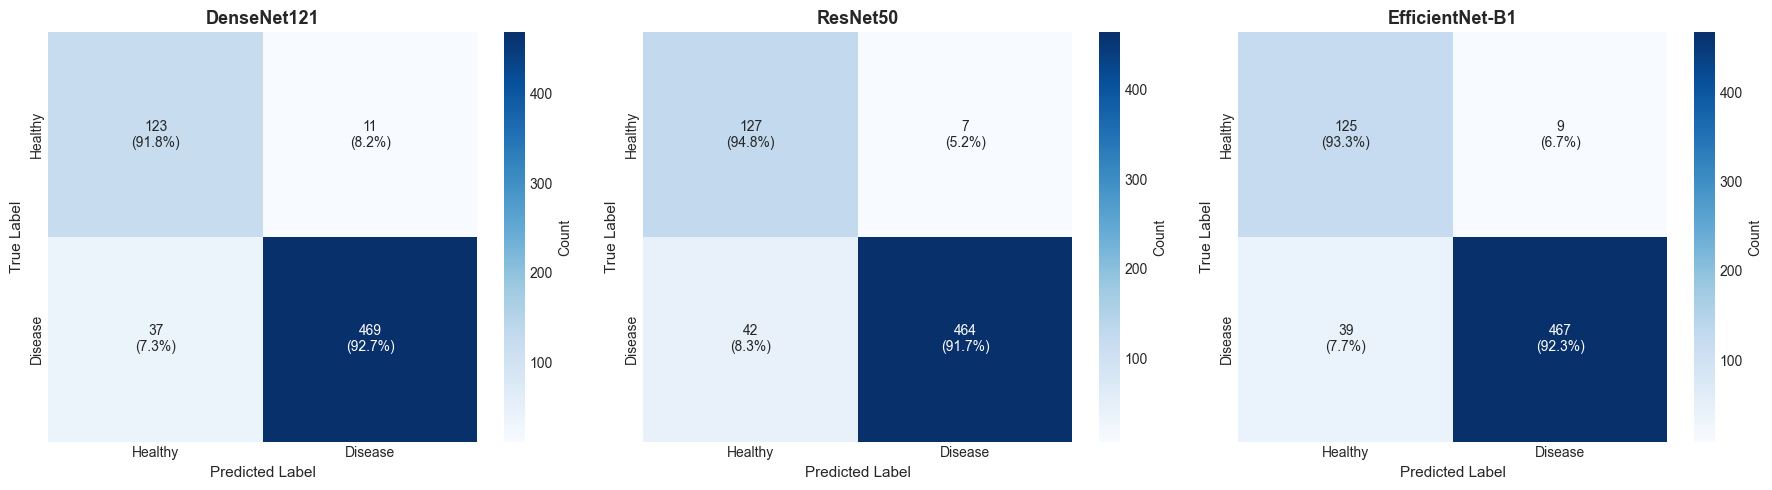

In [9]:
plot_confusion_matrices(all_results)

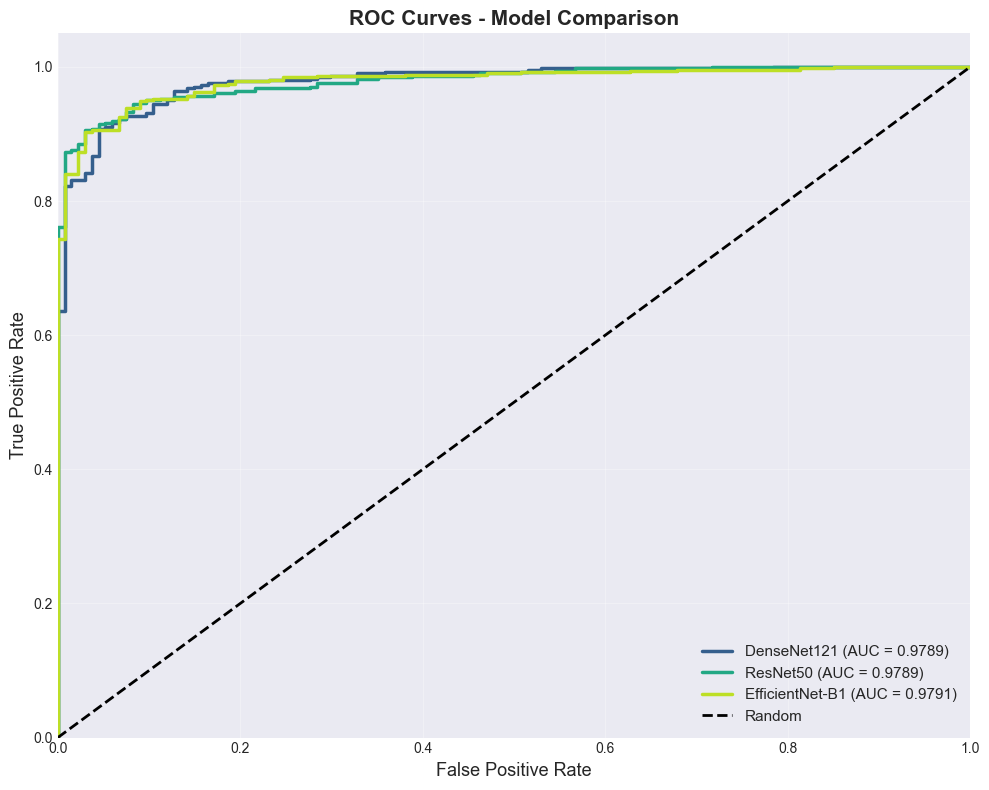

In [10]:
plot_roc_curves(all_results)

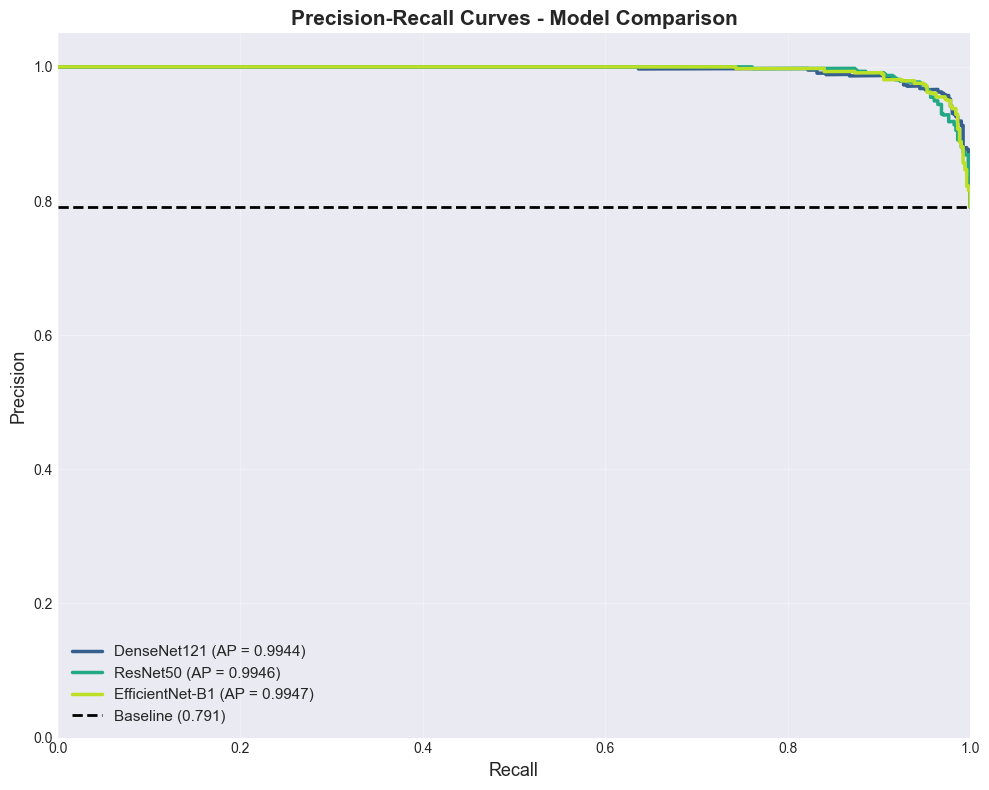

In [12]:
plot_pr_curves(all_results)

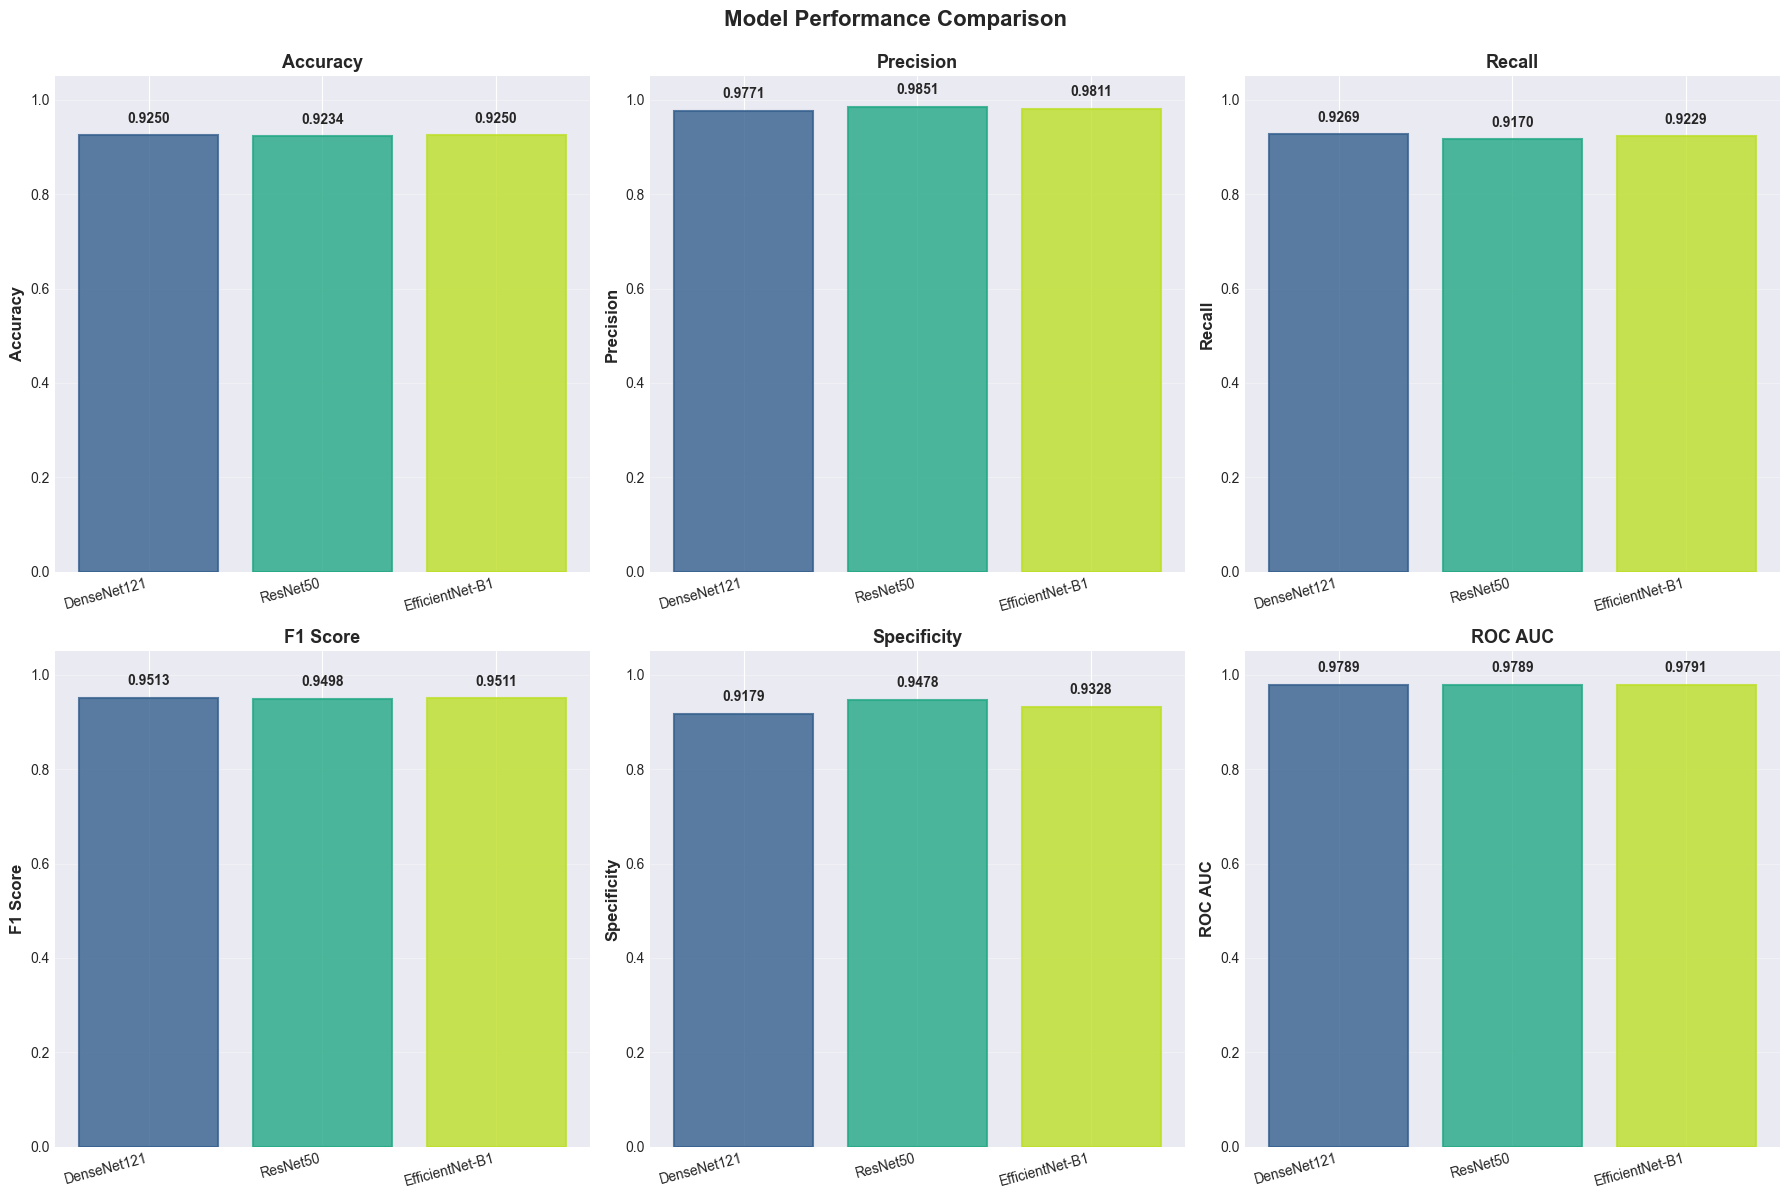

In [13]:
plot_metrics_comparison(all_results)

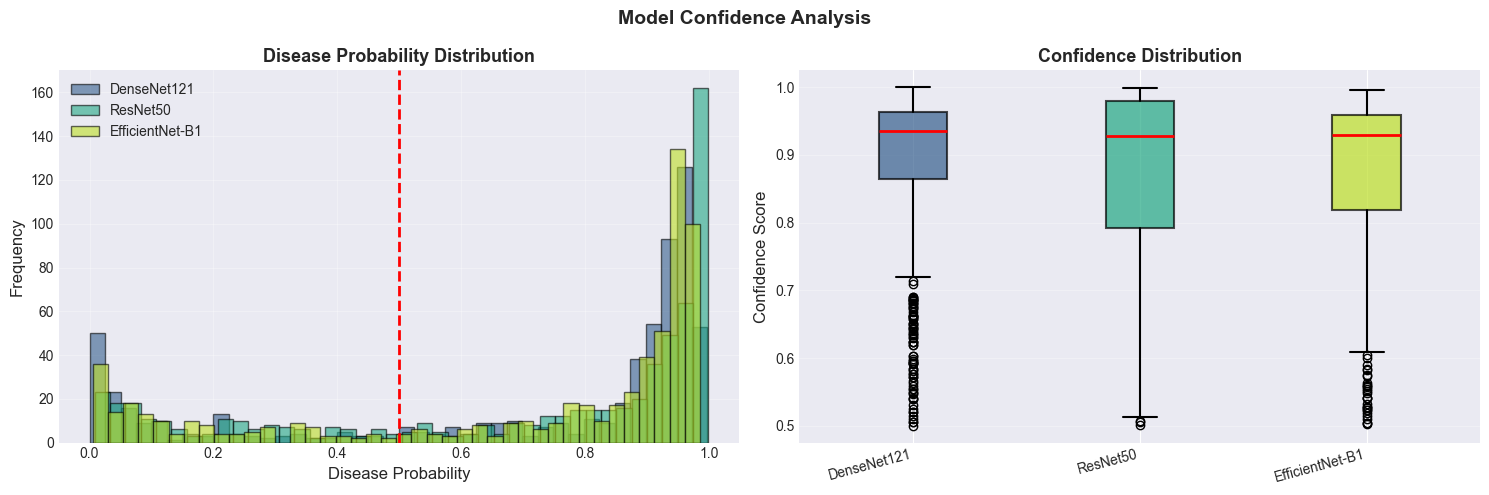

In [14]:
plot_confidence_distributions(all_results)